In [2]:
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

def extract_entities_and_relations_from_file(json_file_path) :
    entities = set()
    relations = []

    try :
        with open(json_file_path, 'r', encoding="utf-8") as f :
            data = json.load(f)
    except FileNotFoundError as e :
        print(f"파일 {json_file_path} 찾을 수 없음")
        return set(), []
    except json.JSONDecodeError as e :
        print(f"json 디코딩 실패 : {json_file_path}")
        return set(), []
    
    if "paragraphs_data" in data :
        for paragraph in data["paragraphs_data"] :
            if "entities" in paragraph :
                for entity in paragraph["entities"] :
                    if "name" in entity and "type" in entity :
                        if entity["name"] and entity["type"] :
                            entities.add((entity["name"], entity["type"]))
                        elif entity["name"] and not entity["type"] :
                            entities.add((entity["name"], "UNKNOWN_TYPE"))
                        elif not entity["name"] and entity["type"] :
                            entities.add("UNKNOWN_TYPE", entity["type"])

            if "relations" in paragraph :
                for relation in paragraph["relations"] :
                    if all(k in relation for k in ["head", "relation", "tail"]) :
                        relations.append(relation)

    return entities, relations

In [ ]:
import json
import os

json_files_directory = './data/extracted_results' 

def replace_spaces_in_entity_types(directory_path):
    if not os.path.exists(directory_path):
        print(f"오류: 지정된 폴더 '{directory_path}'를 찾을 수 없습니다.")
        print("폴더 경로를 확인하거나 JSON 파일들을 해당 경로에 넣어주세요.")
        return

    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            file_path = os.path.join(directory_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                if "paragraphs_data" in data and isinstance(data["paragraphs_data"], list):
                    for paragraph in data["paragraphs_data"]:
                        if "entities" in paragraph and isinstance(paragraph["entities"], list):
                            for entity in paragraph["entities"]:
                                if "type" in entity and isinstance(entity["type"], str):
                                    entity["type"] = entity["type"].replace(' ', '_')
                
                with open(file_path, 'w', encoding='utf-8') as f:
                    json.dump(data, f, indent=4, ensure_ascii=False)
                
                print(f"'{filename}' 파일의 'entities.type' 필드 공백이 성공적으로 대체되었습니다.")
            
            except json.JSONDecodeError:
                print(f"경고: '{filename}' 파일이 유효한 JSON 형식이 아닙니다. 건너뜝니다.")
            except Exception as e:
                print(f"오류: '{filename}' 파일 처리 중 예상치 못한 오류 발생: {e}")

if __name__ == "__main__":
    replace_spaces_in_entity_types(json_files_directory)

경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {'head': 'framework', 'relation': 'part_of', 'tail': 'body'}
경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {'head': 'framework', 'relation': 'part_of', 'tail': 'bones'}
경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {'head': 'framework', 'relation': 'part_of', 'tail': 'cartilage'}
경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {'head': 'skeleton', 'relation': 'part_of', 'tail': 'framework'}
경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {'head': 'Upper extremities', 'relation': 'part_of', 'tail': 'Appendicular'}
경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {'head': 'patellæ', 'relation': 'part_of', 'tail': 'enumeration'}
경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {'head': 'sesamoid bones', 'relation': 'part_of', 'tail': 'enumeration'}
경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {'head': 'Bones', 'relation': 'divisible_into', 'tail': 'classes'}
경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {'head': 'Long', 'relation': 'part_of', 'tail': 'classes'}
경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {'head': 'Short', 'relation': 'part_of', 'tail': 'classes'}
경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {'h

/tmp/ipykernel_464688/396159181.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_node_types))


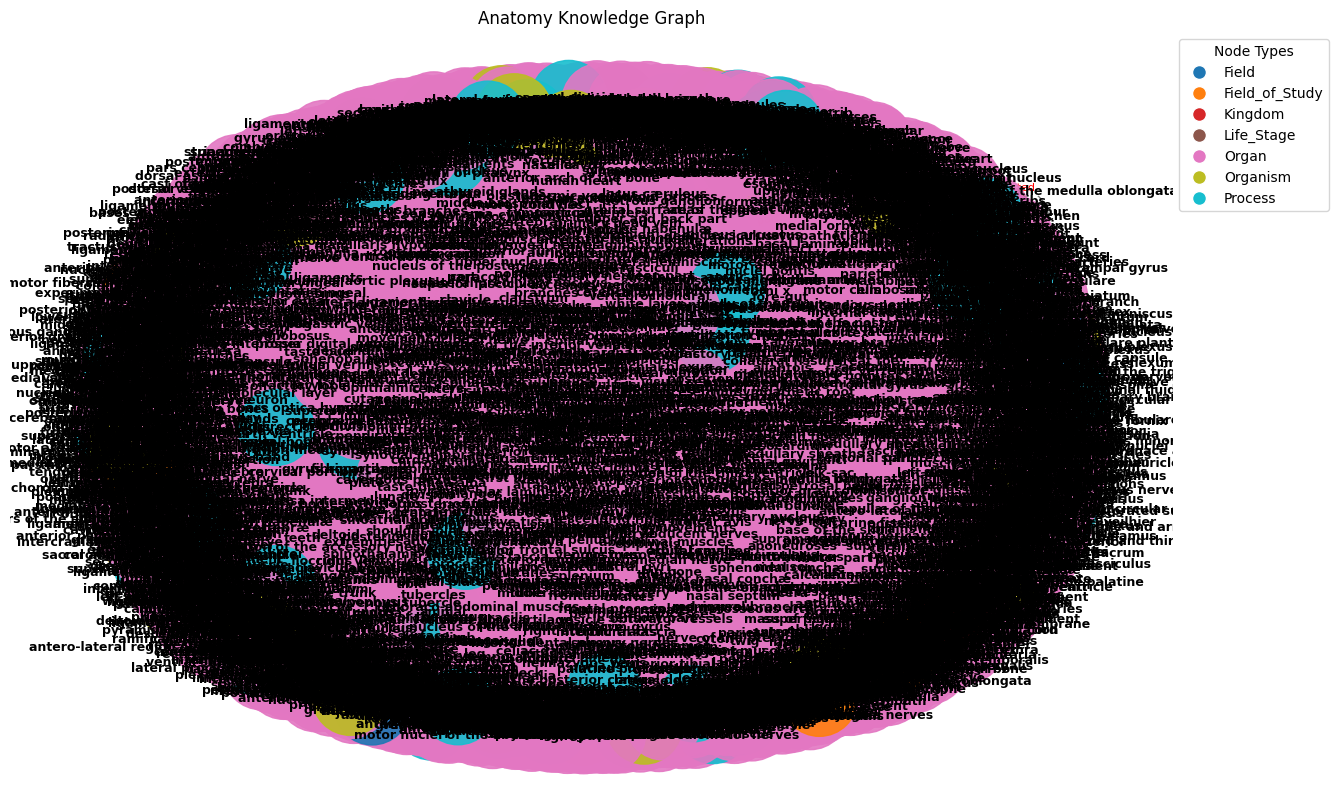

In [ ]:
import pickle
import matplotlib.cm as cm

def build_knowledge_graph(json_files_directory) :
    G = nx.DiGraph()
    all_entities_info = {}
    all_relations = []

    for filename in os.listdir(json_files_directory) :
        if filename.endswith(".json") :
            json_file_path = os.path.join(json_files_directory, filename)
            entities_from_file, relations_from_file = extract_entities_and_relations_from_file(json_file_path)

            for name, type_ in entities_from_file :
                all_entities_info[name] = type_
            all_relations.extend(relations_from_file)

    for name, type_ in all_entities_info.items() :
        G.add_node(name, type=type_)

    for rel_dict in all_relations :
        head = rel_dict["head"]
        tail = rel_dict["tail"]
        relation_type = rel_dict["relation"]

        if head in G and tail in G :
            G.add_edge(head, tail, relation=relation_type)
        else :
            print(f"경고 : 그래프에 없는 엔티티를 포함하는 관계 발견 : {rel_dict}")

    return G

def save_graph(graph, file_path) :
    try :
        with open(file_path, "wb") as f :
            pickle.dump(graph, f)
    except Exception as e :
        print(f"그래프 저장 중 오류 : {e}")

def load_graph(file_path) :
    if os.path.exists(file_path) :
        try :
            with open(file_path, 'rb') as f :
                graph = pickle.load(f)
            return graph
        except Exception as e :
            print(f"그래프 로드 중 오류 : {e}")
            return None
    return None

def visualize_knowledge_graph(graph, title="Knowledge Graph"):
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(graph, k=0.3, iterations=50)

    unique_node_types = set()
    for node_name in graph.nodes:
        unique_node_types.add(graph.nodes[node_name].get("type", "UNKNOWN_TYPE"))
    
    cmap = cm.get_cmap('tab10', len(unique_node_types)) 
    
    dynamic_type_colors = {}
    for i, node_type in enumerate(sorted(list(unique_node_types))): 
        dynamic_type_colors[node_type] = cmap(i) 

    node_colors = []
    for node_name in graph.nodes:
        node_type = graph.nodes[node_name].get("type", "UNKNOWN_TYPE")
        node_colors.append(dynamic_type_colors.get(node_type, "grey")) 

    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=3000, alpha=0.9)
    nx.draw_networkx_labels(graph, pos, font_size=9, font_weight="bold")

    nx.draw_networkx_edges(graph, pos, edgelist=graph.edges, alpha=0.5, arrowstyle='->', arrowsize=20)

    edge_labels = nx.get_edge_attributes(graph, "relation")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color="red", font_size=8)

    plt.title(title)
    plt.axis("off")
    
    handles = []
    labels = []
    for node_type, color in dynamic_type_colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
        labels.append(node_type)
    plt.legend(handles, labels, title="Node Types", loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    
    plt.show()

if __name__ == "__main__" :
    json_dir = "./data/extracted_results"
    graph_pickle_path = "./data/knowledge_graph.pickle"

    knowledge_graph = load_graph(graph_pickle_path)

    if knowledge_graph is None :
        knowledge_graph = build_knowledge_graph(json_dir)
        save_graph(knowledge_graph, graph_pickle_path)
    else :
        print("기존 pickle 파일 로드")
    print(f"노드 수 : {knowledge_graph.number_of_nodes()}")
    print(f"엣지 수 : {knowledge_graph.number_of_edges()}")

    for i, node in enumerate(knowledge_graph.nodes(data=True)) :
        if i >= 10 : break
        print(node)

    for i, edge in enumerate(knowledge_graph.edges(data=True)) :
        if i >= 10 : break
        print(edge)

    print("\n지식그래프 시각화 시작")
    visualize_knowledge_graph(knowledge_graph, title="Anatomy Knowledge Graph")

In [8]:
import os

def extract_unique_types_from_txt_files(directory):
    unique_types = set()

    if not os.path.isdir(directory):
        print(f"오류: 디렉토리를 찾을 수 없습니다: {directory}")
        return unique_types

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    for line in f:
                        line = line.strip()
                        if "타입 :" in line:
                            parts = line.split("타입 :", 1)
                            if len(parts) > 1:
                                entity_type = parts[1].strip()
                                if entity_type: 
                                    unique_types.add(entity_type)
            except Exception as e:
                print(f"오류: 파일 '{filepath}' 처리 중 문제가 발생했습니다: {e}")
    return list(unique_types)

if __name__ == "__main__":
    unique_files_directory = "./data/unique"
    
    extracted_types = extract_unique_types_from_txt_files(unique_files_directory)
    
    print("--- 모든 TXT 파일에서 추출된 고유한 타입 ---")
    if extracted_types:
        for entity_type in sorted(list(extracted_types)):
            print(f"타입: {entity_type}")
    else:
        print("추출된 타입이 없습니다.")
    print(f"총 개수 : {len(extracted_types)}")
    

--- 모든 TXT 파일에서 추출된 고유한 타입 ---
타입: Abnormality
타입: Action
타입: Activity
타입: Anatomical Direction
타입: Anatomical Feature
타입: Anatomical Group
타입: Anatomical Landmark
타입: Anatomical Location
타입: Anatomical Measurement
타입: Anatomical Region
타입: Anatomical Structure
타입: Anatomical Surface
타입: Anatomical_Feature
타입: Anatomical_Line
타입: Anatomical_Location
타입: Anatomical_Notch
타입: Anatomical_Part
타입: Anatomical_Region
타입: Anatomical_Side
타입: Anatomical_Structure
타입: Anatomical_Surface
타입: Anatomy
타입: Angle
타입: Animal
타입: Apex
타입: Arch
타입: Area
타입: Artery
타입: Articulation
타입: Aspect
타입: Author
타입: Axis
타입: Band
타입: Biological Concept
타입: Biological Entity
타입: Biological Feature
타입: Biological Need
타입: Biological Process
타입: Biological Sample
타입: Biological Structure
타입: Biological_Process
타입: Biological_Sex
타입: Biological_Structure
타입: Biological_Unit
타입: Biomechanical Force
타입: Blood Vessel
타입: Blood_Vessel
타입: Body
타입: Body Cavity
타입: Body Part
타입: Body_Cavity
타입: Body_Feature
타입: Body_Form


# 개체 타입 정규화
띄어쓰기 -> 언더바로 대체

대문자 -> 소문자로 대체

json파일의 type의 값이 정제한 타입 리스트에 포함되지 않는 경우 제거

In [5]:
import json
import os

type_list = ["Field_of_Study", "Process", "Organism", "Organ", "Life_Stage", "Field", "Kingdom"]

input_folder_path = './data/extracted_results' 

# def get_singular_form(word):
#     if word.endswith('ies'):
#         return word[:-3] + 'y'
#     elif word.endswith('es'):
#         if len(word) > 2 and word[-3] in ['s', 'x', 'z', 'ch', 'sh']: 
#             return word[:-2]
#         else: 
#             return word[:-2]
#     elif word.endswith('s') and len(word) > 1 and word[-2] not in ['s', 'x', 'z', 'ch', 'sh']: 
#         return word[:-1]
#     return word 

def process_json_data(data):
    for paragraph in data.get("paragraphs_data", []):
        consolidated_entities_map = {}
        for entity in paragraph.get("entities", []):
            raw_name = entity.get("name", "")
            raw_type = entity.get("type", "")

            processed_type = raw_type.replace(' ', '_')

            processed_name = raw_name.lower()

            if processed_type in type_list:
                if processed_name not in consolidated_entities_map:
                    consolidated_entities_map[processed_name] = {'name': processed_name, 'types': set()}
                consolidated_entities_map[processed_name]['types'].add(processed_type)

        new_paragraph_entities = []
        for name, info in consolidated_entities_map.items():
            possible_types = [t for t in info['types'] if t in type_list]
            if possible_types:
                chosen_type = possible_types[0]
                new_paragraph_entities.append({'name': name, 'type': chosen_type})
        
        paragraph['entities'] = new_paragraph_entities
    return data

if __name__ == "__main__":
    if not os.path.exists(input_folder_path):
        print(f"오류: 지정된 폴더 '{input_folder_path}'를 찾을 수 없습니다.")
    else:
        for filename in os.listdir(input_folder_path):
            if filename.endswith('.json'):
                file_path = os.path.join(input_folder_path, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                    
                    processed_data = process_json_data(data)
                    
                    with open(file_path, 'w', encoding='utf-8') as f:
                        json.dump(processed_data, f, indent=4, ensure_ascii=False)
                    print(f"'{filename}' 파일이 성공적으로 처리되었습니다.")
                except json.JSONDecodeError:
                    print(f"'{filename}' 파일이 유효한 JSON 형식이 아닙니다. 건너뜝니다.")
                except Exception as e:
                    print(f"'{filename}' 파일 처리 중 오류 발생: {e}")

'2_Osteology.json' 파일이 성공적으로 처리되었습니다.
'3_Syndesmology.json' 파일이 성공적으로 처리되었습니다.
'4_Myology.json' 파일이 성공적으로 처리되었습니다.
'5_Angiology.json' 파일이 성공적으로 처리되었습니다.
'9_Neurology.json' 파일이 성공적으로 처리되었습니다.
'1_Embryology.json' 파일이 성공적으로 처리되었습니다.
